In [1]:
# !pip install -q pytorch-lightning
# !pip install -q optuna
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import pytorch_lightning as pl
import seaborn as sns
import torch
import torch.nn as nn
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer
from torch.utils.data import DataLoader, TensorDataset
from torchmetrics import Accuracy, MetricCollection

/Users/ksterx/Development/miniforge3/envs/ray/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# !wget https://raw.githubusercontent.com/UTDataMining/2022A/master/project/winequality-white.csv

In [3]:
wine = pd.read_csv("winequality-white.csv", sep=";")

array([[<AxesSubplot: title={'center': 'fixed acidity'}>,
        <AxesSubplot: title={'center': 'volatile acidity'}>,
        <AxesSubplot: title={'center': 'citric acid'}>],
       [<AxesSubplot: title={'center': 'residual sugar'}>,
        <AxesSubplot: title={'center': 'chlorides'}>,
        <AxesSubplot: title={'center': 'free sulfur dioxide'}>],
       [<AxesSubplot: title={'center': 'total sulfur dioxide'}>,
        <AxesSubplot: title={'center': 'density'}>,
        <AxesSubplot: title={'center': 'pH'}>],
       [<AxesSubplot: title={'center': 'sulphates'}>,
        <AxesSubplot: title={'center': 'alcohol'}>,
        <AxesSubplot: title={'center': 'quality'}>]], dtype=object)

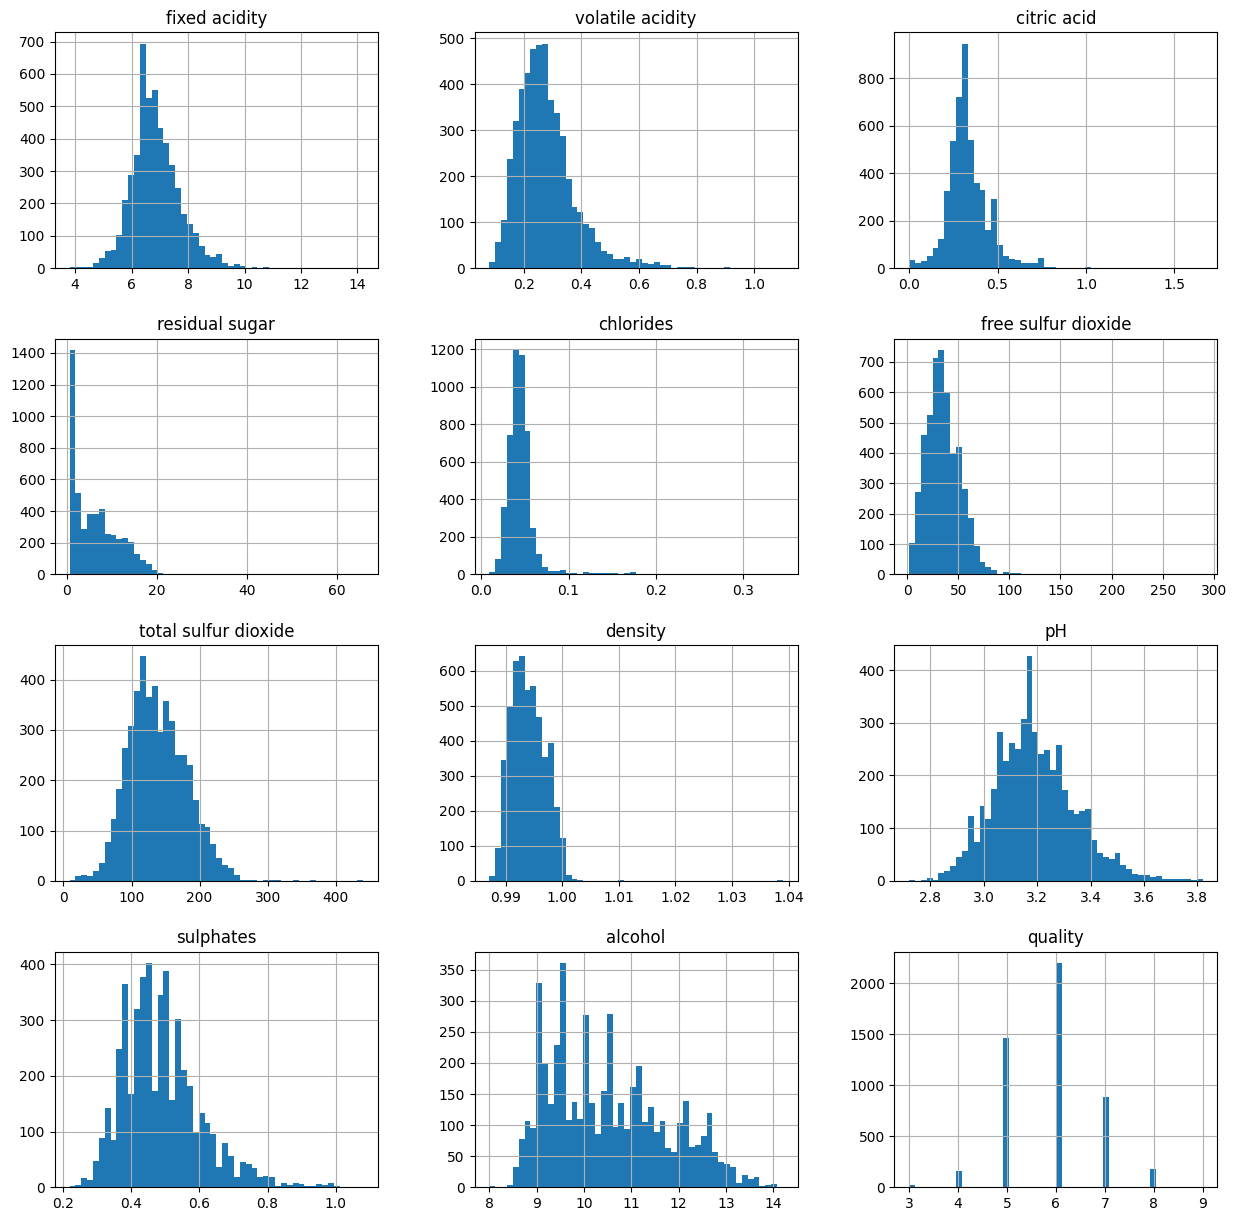

In [4]:
wine.hist(bins=50, figsize=(15, 15))

In [5]:
wine.corr(method="pearson")

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,-0.022697,0.289181,0.089021,0.023086,-0.049396,0.091070,0.265331,-0.425858,-0.017143,-0.120881,-0.113663
volatile acidity,-0.022697,1.000000,-0.149472,0.064286,0.070512,-0.097012,0.089261,0.027114,-0.031915,-0.035728,0.067718,-0.194723
citric acid,0.289181,-0.149472,1.000000,0.094212,0.114364,0.094077,0.121131,0.149503,-0.163748,0.062331,-0.075729,-0.009209
residual sugar,0.089021,0.064286,0.094212,1.000000,0.088685,0.299098,0.401439,0.838966,-0.194133,-0.026664,-0.450631,-0.097577
chlorides,0.023086,0.070512,0.114364,0.088685,1.000000,0.101392,0.198910,0.257211,-0.090439,0.016763,-0.360189,-0.209934
free sulfur dioxide,-0.049396,-0.097012,0.094077,0.299098,0.101392,1.000000,0.615501,0.294210,-0.000618,0.059217,-0.250104,0.008158
total sulfur dioxide,0.091070,0.089261,0.121131,0.401439,0.198910,0.615501,1.000000,0.529881,0.002321,0.134562,-0.448892,-0.174737
density,0.265331,0.027114,0.149503,0.838966,0.257211,0.294210,0.529881,1.000000,-0.093591,0.074493,-0.780138,-0.307123
pH,-0.425858,-0.031915,-0.163748,-0.194133,-0.090439,-0.000618,0.002321,-0.093591,1.000000,0.155951,0.121432,0.099427
sulphates,-0.017143,-0.035728,0.062331,-0.026664,0.016763,0.059217,0.134562,0.074493,0.155951,1.000000,-0.017433,0.053678


In [6]:
X = wine[
    [
        "fixed acidity",
        "volatile acidity",
        "citric acid",
        "residual sugar",
        "chlorides",
        "free sulfur dioxide",
        "total sulfur dioxide",
        "density",
        "pH",
        "sulphates",
        "alcohol",
    ]
].values

y = wine["quality"].values
y = (y >= 6).astype(int)
print(np.sum(y == 1, axis=0))
print(np.sum(y == 0, axis=0))

3258
1640


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [8]:
lr = LogisticRegression(solver="liblinear", multi_class="auto")
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

[[158 170]
 [ 75 577]]
0.75
0.7724230254350736
0.8849693251533742
0.8248749106504645


In [9]:
class WineModel(pl.LightningModule):
    NUM_FEATURES = 11
    OUTPUT_SIZE = 2

    def __init__(self, hidden_size, lr, l2_lambda):
        super().__init__()
        self.lr = lr
        self.l2_lambda = l2_lambda

        self.loss_fn = nn.CrossEntropyLoss()
        metrics = MetricCollection([Accuracy(task="multiclass", num_classes=2)])
        self.train_metrics = metrics.clone(prefix="train_")
        self.val_metrics = metrics.clone(prefix="val_")

        # sequential model with batch normalization
        self.net = nn.Sequential(
            nn.Linear(self.NUM_FEATURES, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, self.OUTPUT_SIZE),
        )

    def forward(self, x):
        return self.net(x.to(torch.float32))

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.l2_lambda)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=5)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_epoch_loss"}

    def training_step(self, batch, batch_index):
        x, target = batch
        pred = self(x)
        loss = self.loss_fn(pred, target)
        self.train_metrics(pred, target)
        self.log("train_loss", loss, prog_bar=True, logger=True, on_step=True, on_epoch=True, sync_dist=True)
        self.log_dict(self.train_metrics, prog_bar=False, logger=True, on_step=True, on_epoch=True, sync_dist=True)
        return {
            "loss": loss,
            "target": target,
            "pred": pred,
        }

    def validation_step(self, batch, batch_index):
        x, target = batch
        pred = self(x)
        loss = self.loss_fn(pred, target)
        self.val_metrics(pred, target)
        self.log("val_loss", loss, prog_bar=True, logger=True, on_step=True, on_epoch=False, sync_dist=True)
        self.log_dict(self.val_metrics, prog_bar=False, logger=True, on_step=True, on_epoch=True, sync_dist=True)
        return {
            "loss": loss,
            "target": target,
            "pred": pred,
        }

    def training_epoch_end(self, outputs):
        avg_loss = torch.stack([x["loss"] for x in outputs]).mean()
        self.log("train_epoch_loss", avg_loss, prog_bar=True, logger=True, on_step=False, on_epoch=True, sync_dist=True)

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x["loss"] for x in outputs]).mean()
        self.log("val_epoch_loss", avg_loss, prog_bar=True, logger=True, on_step=False, on_epoch=True, sync_dist=True)


In [10]:
class WineData(pl.LightningDataModule):
    FEATURES = [
        "fixed acidity",
        "volatile acidity",
        "citric acid",
        "residual sugar",
        "chlorides",
        "free sulfur dioxide",
        "total sulfur dioxide",
        "density",
        "pH",
        "sulphates",
        "alcohol",
    ]

    def __init__(self, batch_size, X_train, X_test, y_train, y_test, iqr_thresholds, remove_outliers=True, viz=False):
        super().__init__()

        self.X_train = X_train
        self.batch_size = batch_size
        self.iqr_thresholds = iqr_thresholds
        self.remove_outliers = remove_outliers

        if viz:
            self._plot(X_train, "Before preprocessing")

        # Preprocess data
        self.pt = PowerTransformer()
        X_train_7 = X_train[:, 7]
        X_test_7 = X_test[:, 7]
        X_train = self.pt.fit_transform(X_train)
        X_test = self.pt.transform(X_test)
        X_train[:, 7] = X_train_7
        X_test[:, 7] = X_test_7

        if viz:
            self._plot(X_train, "After yeo-johnson transformation")
        
        if remove_outliers:
            X_train, y_train = self._remove_outliers(X_train, y_train)
        self.scaler = StandardScaler()
        X_train_norm = self.scaler.fit_transform(X_train)
        X_test_norm = self.scaler.transform(X_test)

        if viz:
            self._plot(X_train_norm, "After normalization")

        self.X_train_norm = torch.from_numpy(X_train_norm)
        self.X_test_norm = torch.from_numpy(X_test_norm)
        self.y_train = torch.from_numpy(y_train)
        self.y_test = torch.from_numpy(y_test)

        self.train_dataset = TensorDataset(self.X_train_norm, self.y_train)
        self.test_dataset = TensorDataset(self.X_test_norm, self.y_test)

    def _remove_outliers(self, x: np.ndarray, y):
        # (iqr_threshold) iqr or higher
        q1 = np.quantile(x, 0.25, axis=0)
        q3 = np.quantile(x, 0.75, axis=0)
        iqr = q3 - q1
        self.lower = q1 - self.iqr_thresholds * iqr
        self.upper = q3 + self.iqr_thresholds * iqr
        mask = (x < self.lower) | (x > self.upper)
        mask = mask.any(axis=1)
        x = x[~mask]
        y = y[~mask]
        return x, y

    def plot(self):
        fig, ax = plt.subplots(4, 3, figsize=(15, 15))
        mean = self.X_train.mean(axis=0)
        lower = self.pt.inverse_transform(self.lower.reshape(1, -1)).squeeze()
        upper = self.pt.inverse_transform(self.upper.reshape(1, -1)).squeeze()
        print(lower, upper)
        for i in range(len(self.FEATURES)):
            sns.histplot(self.X_train[:, i], ax=ax[i // 3, i % 3])
            ax[i // 3, i % 3].axvline(mean[i], color="purple")
            if i != 3 and self.remove_outliers:
                ax[i // 3, i % 3].axvline(lower[i], color="red")
                ax[i // 3, i % 3].axvline(upper[i], color="red")
            ax[i // 3, i % 3].set_title(f"{self.FEATURES[i]}")
        plt.show()

    def _plot(self, x, fig_name, y=None):
        fig, ax = plt.subplots(4, 3, figsize=(15, 15))
        for i in range(len(self.FEATURES)):
            sns.histplot(x[:, i], ax=ax[i // 3, i % 3])
            if y is not None:
                sns.histplot(y[:, i], ax=ax[i // 3, i % 3])
            ax[i // 3, i % 3].set_title(f"{self.FEATURES[i]}")
        fig.suptitle(fig_name)
        plt.show()

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=8, drop_last=True)

    def val_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=8, drop_last=True)


In [11]:
# Hyperparameters
epochs = 100
lr = 1e-4
hidden_size = 1000
batch_size = 32
seed = 22

In [12]:
def objective(trial):
    iqr_threshold = trial.suggest_float("iqr_threshold", 2.5, 5)
    iqr_thresholds = np.ones(11) * iqr_threshold
    l2_lambda = trial.suggest_float("l2_lambda", 1e-6, 1e-4, log=True)

    data = WineData(
        batch_size=batch_size,
        X_train=X_train,
        X_test=X_test,
        y_train=y_train,
        y_test=y_test,
        iqr_thresholds=iqr_thresholds,
    )
    model = WineModel(hidden_size=hidden_size, lr=lr, l2_lambda=l2_lambda)
    logger = TensorBoardLogger("logs", name="wine")
    monitor = "val_MulticlassAccuracy_epoch"
    early_stopping = EarlyStopping(monitor=monitor, mode="max", patience=5)
    model_checkpoint = ModelCheckpoint(monitor=monitor, mode="max", save_top_k=3, save_last=True)
    trainer = pl.Trainer(
        max_epochs=epochs,
        logger=logger,
        callbacks=[early_stopping, model_checkpoint],
        accelerator="cuda",
        devices=1,
    )
    trainer.fit(model, data)
    return trainer.checkpoint_callback.best_model_score.item()

In [13]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)
print(study.best_params)
print(study.best_value)

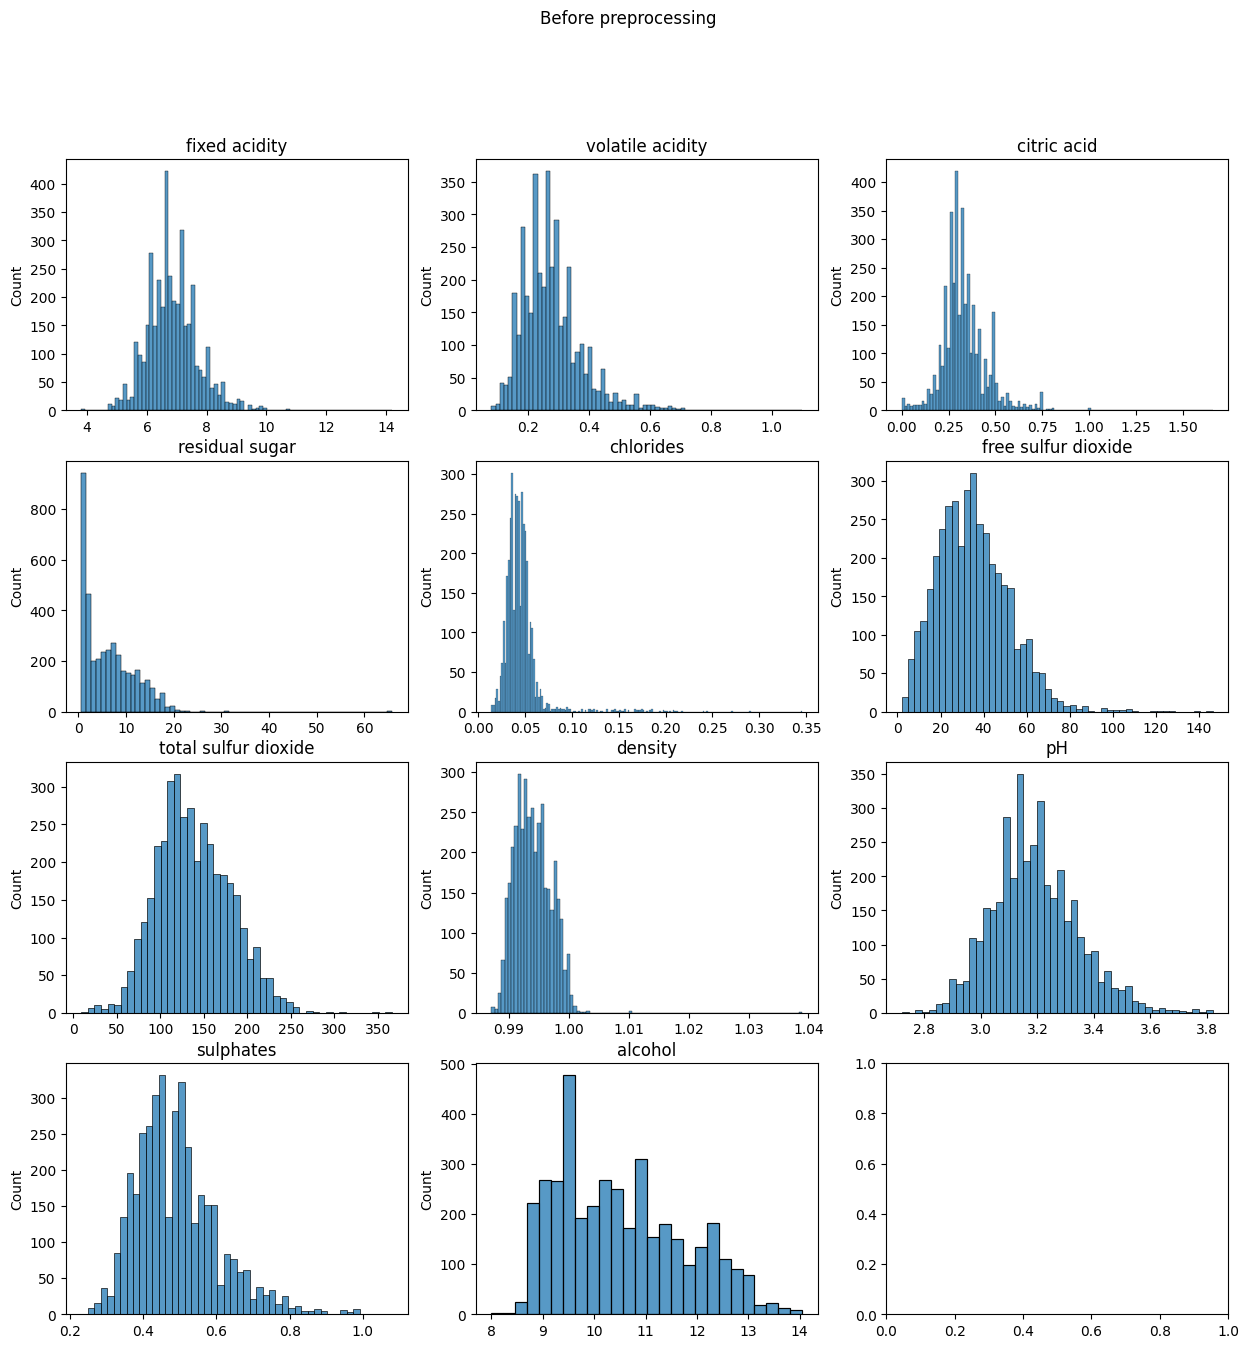

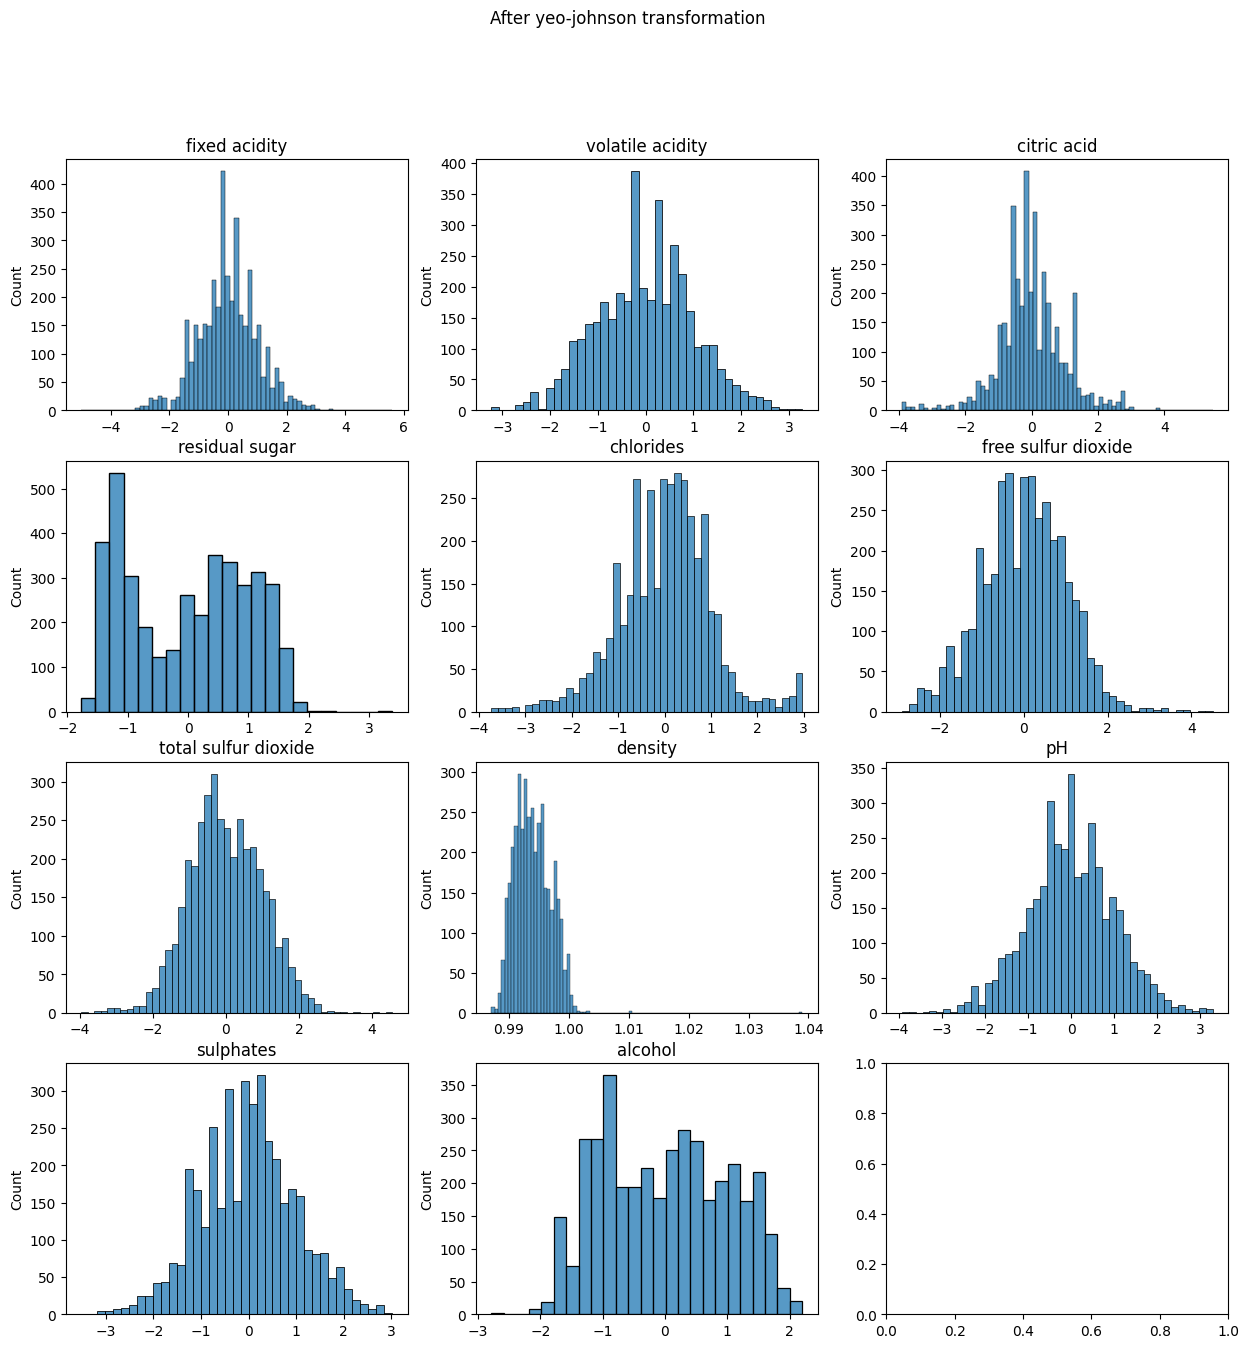

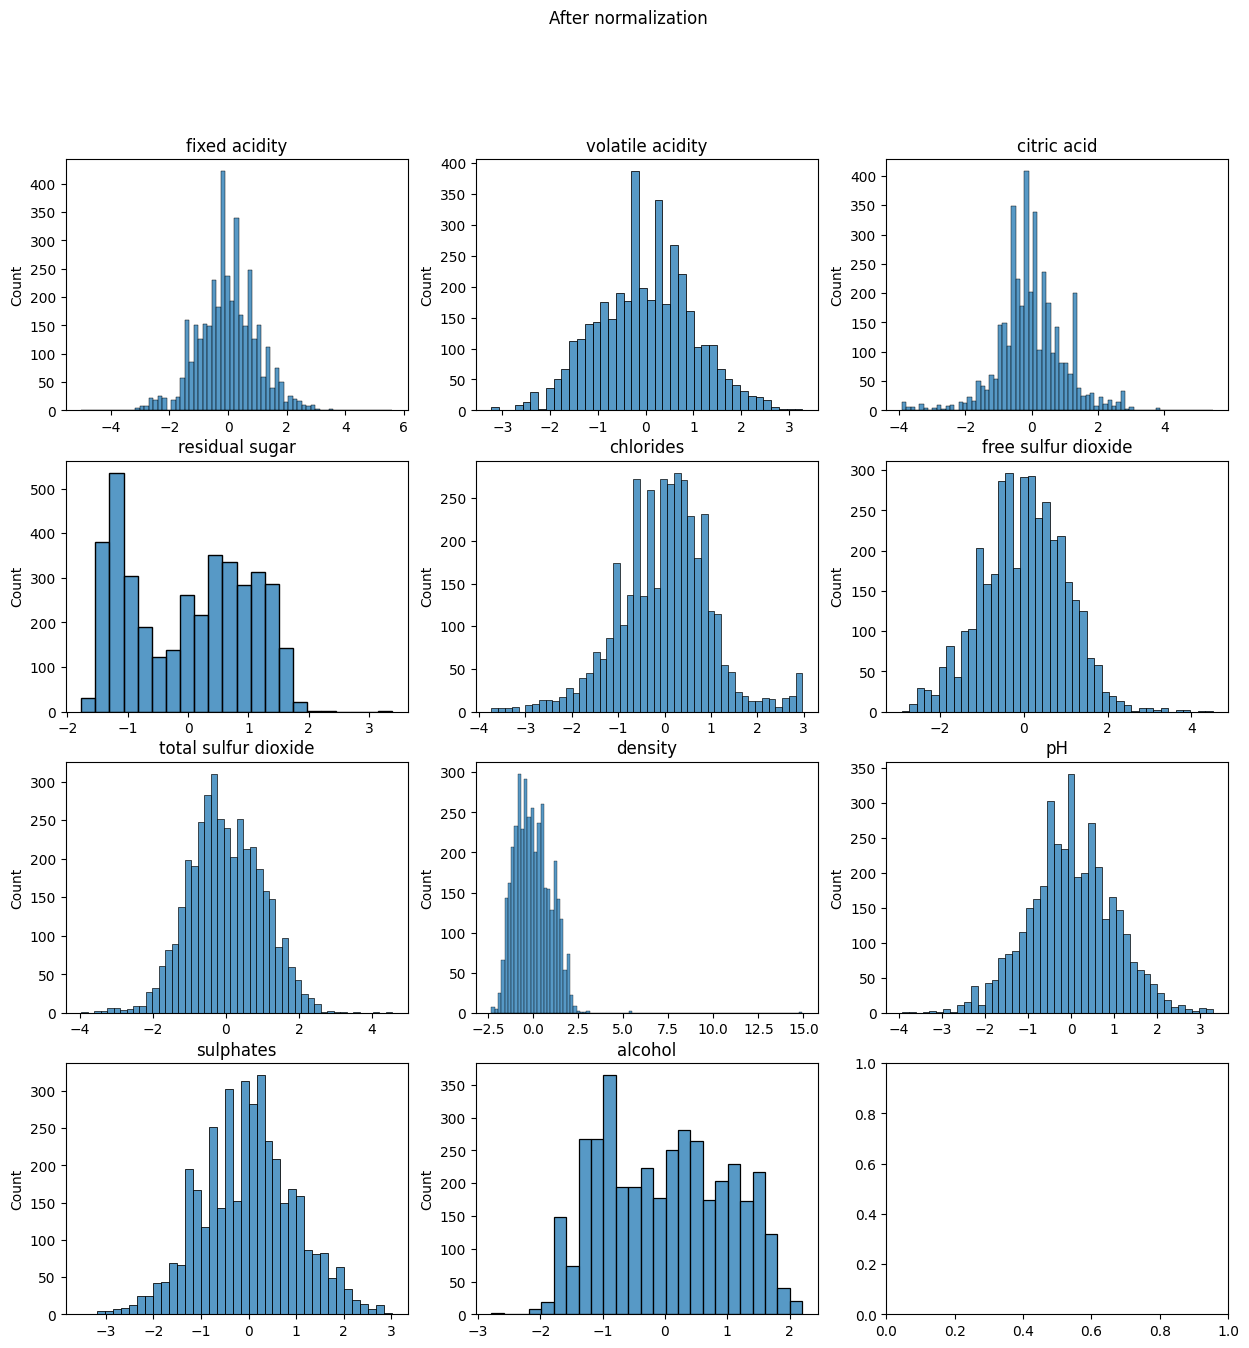

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/ksterx/Development/miniforge3/envs/ray/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:200: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 152/152 [00:03<00:00, 39.00it/s, loss=0.424, v_num=33, train_loss_step=0.400, val_loss=0.611, val_epoch_loss=0.478, train_loss_epoch=0.397, train_epoch_loss=0.397]


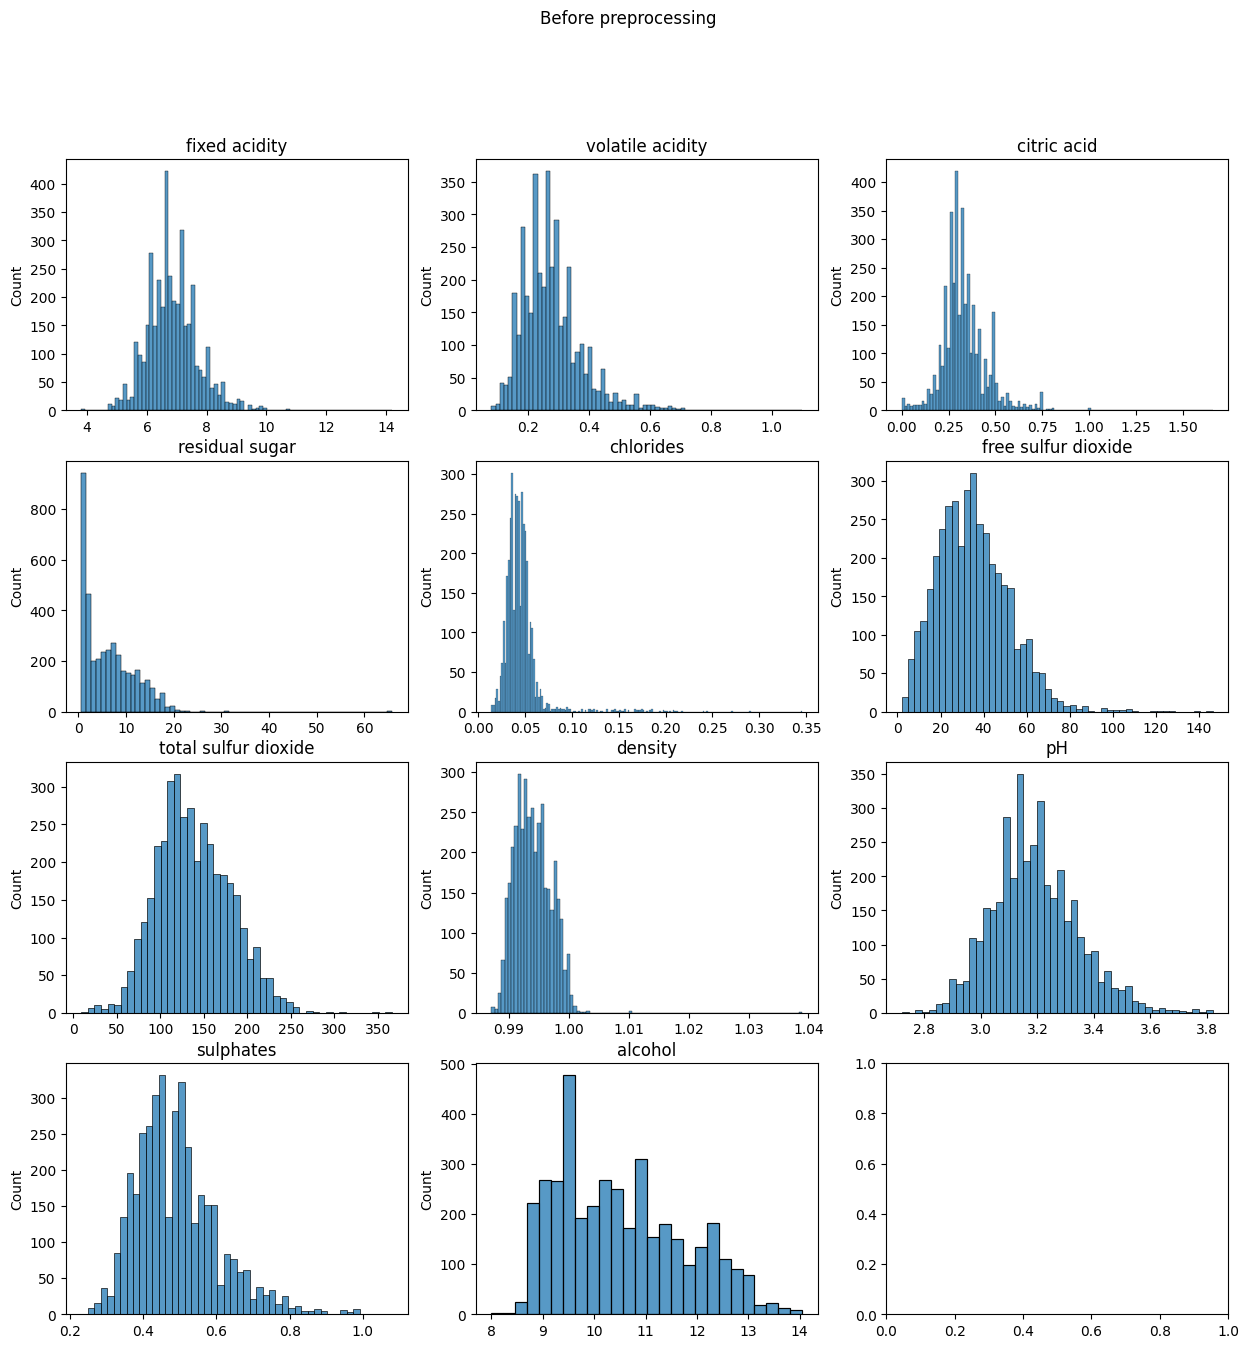

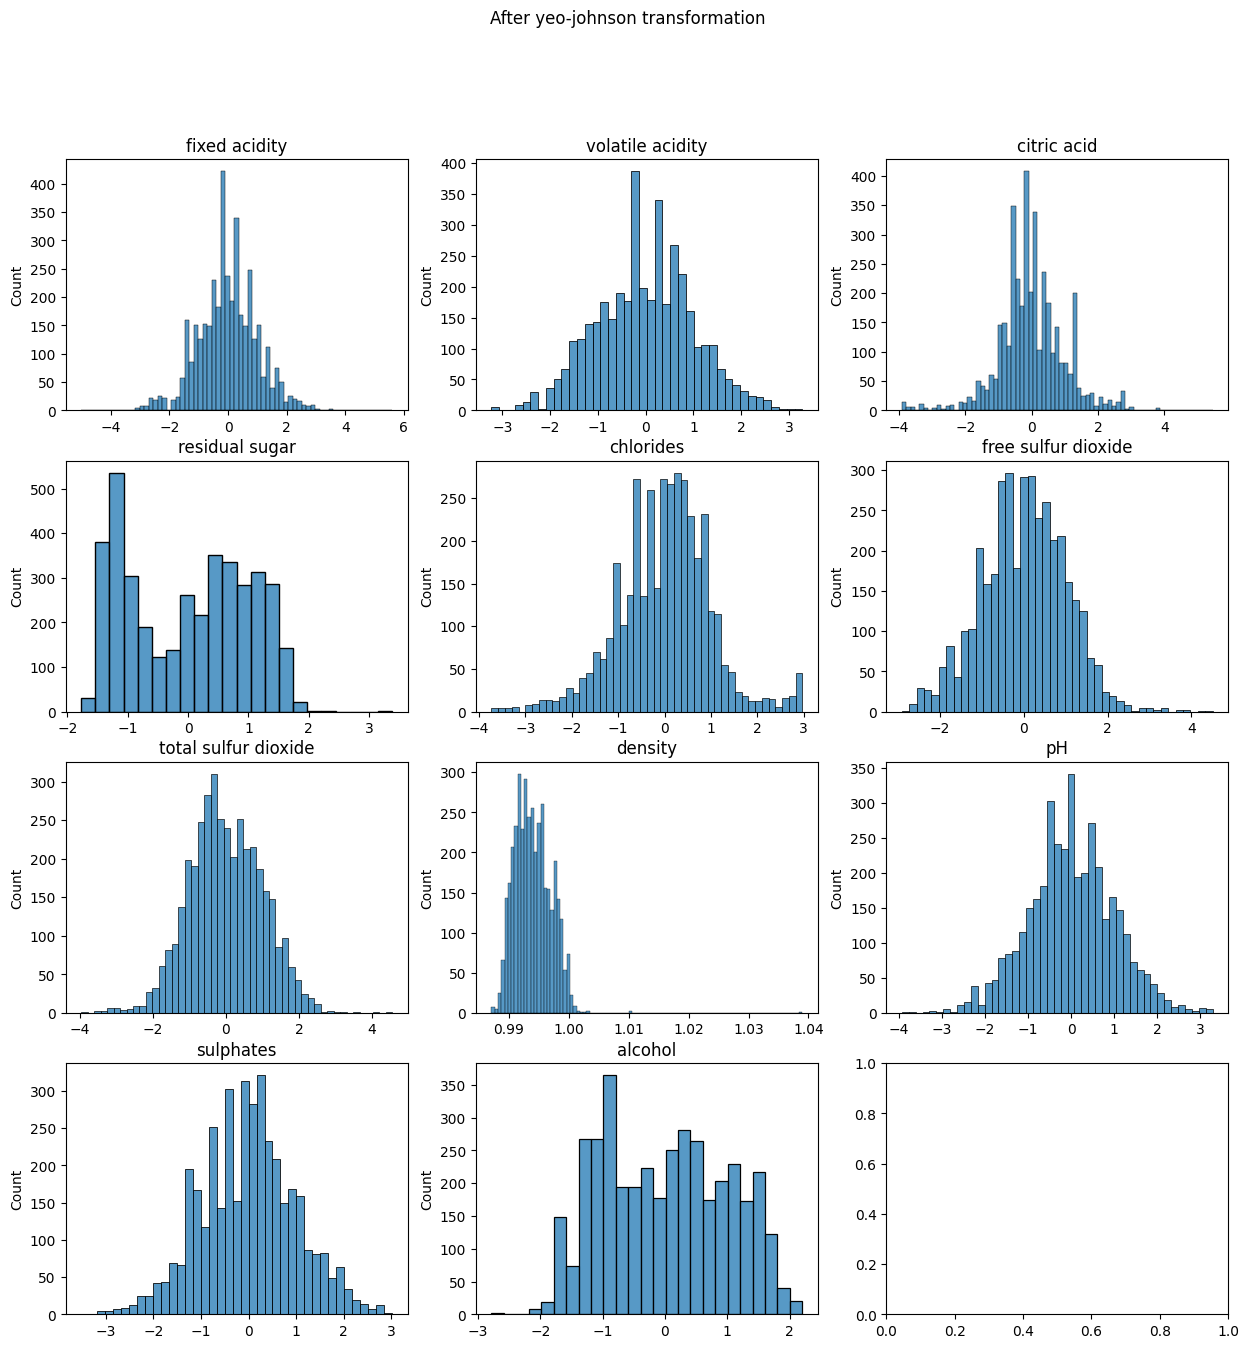

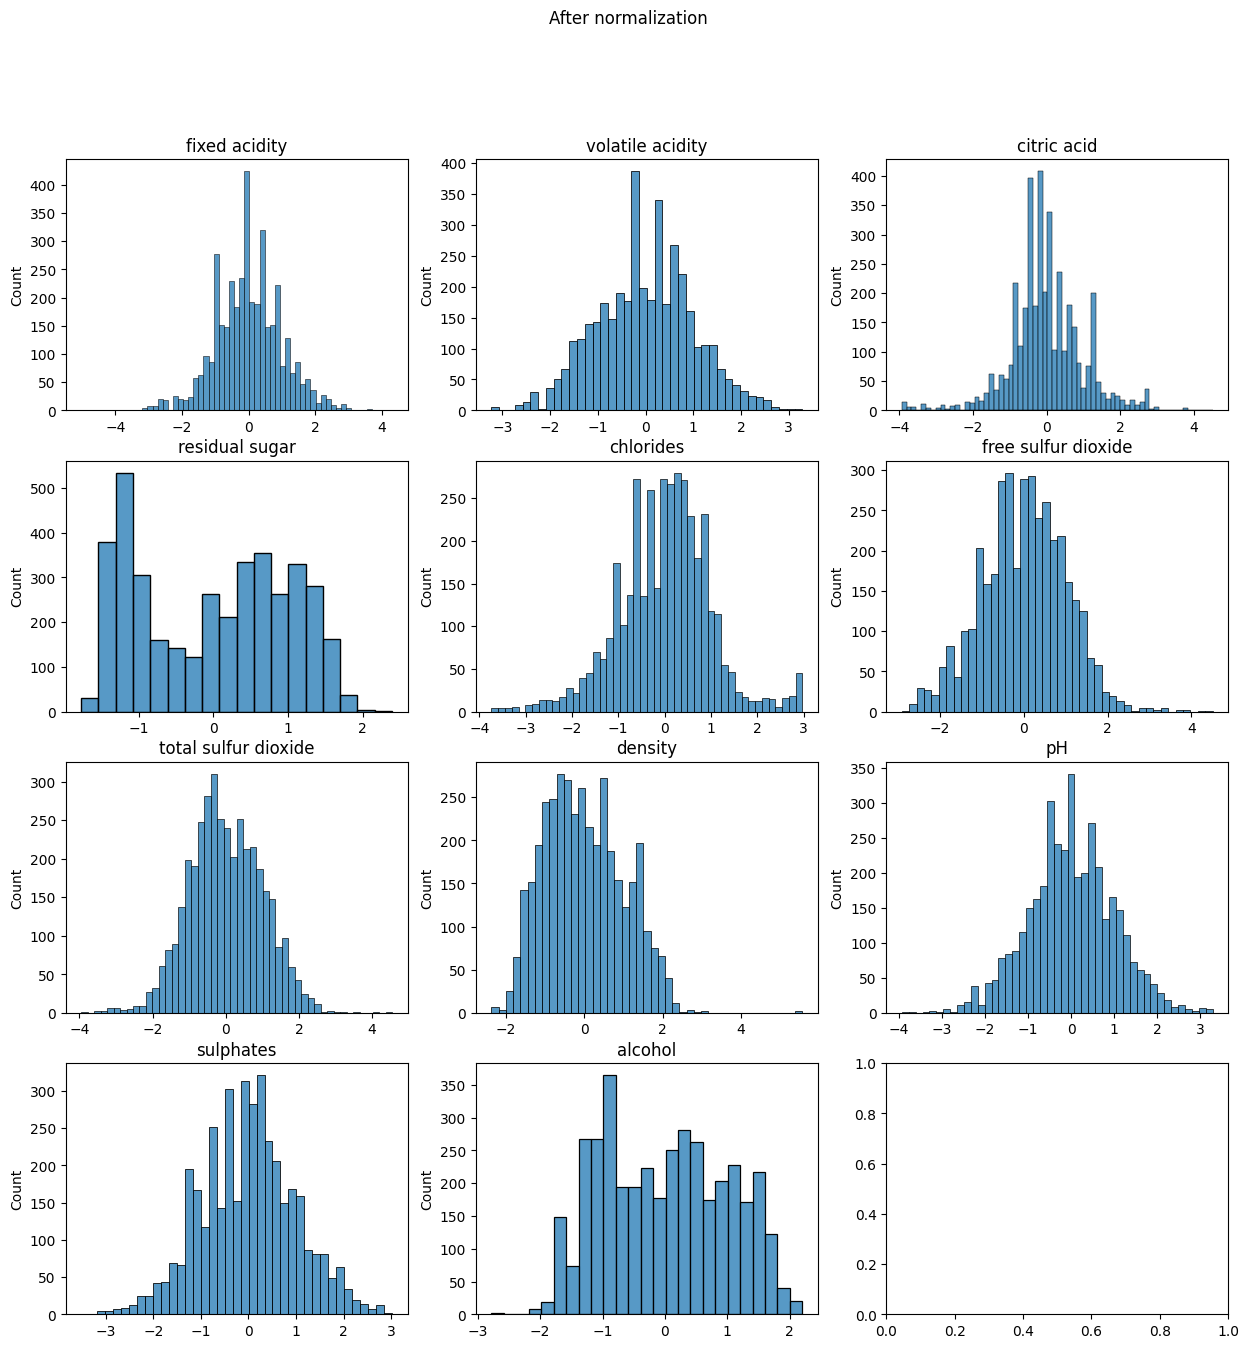

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/ksterx/Development/miniforge3/envs/ray/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:200: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | net           | Sequential       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.076     Total estimated model params size (MB)


Epoch 8: 100%|██████████| 152/152 [00:04<00:00, 37.87it/s, loss=0.441, v_num=34, train_loss_step=0.317, val_loss=0.626, val_epoch_loss=0.481, train_loss_epoch=0.413, train_epoch_loss=0.413]


In [14]:
iqr_threshold = 4.12949373313734
iqr_thresholds = np.ones(11) * iqr_threshold
# iqr_thresholds[1] = 4.01210257871105
# iqr_thresholds[3] = np.inf
# iqr_thresholds[10] = 4.624344562469021
l2_lambda = 9.584267506087667e-6

trainers = []
for remove_outliers in [False, True]:
    torch.manual_seed(seed)
    data = WineData(batch_size=batch_size, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, iqr_thresholds=iqr_thresholds, remove_outliers=remove_outliers, viz=True)
    model = WineModel(hidden_size=hidden_size, lr=lr, l2_lambda=l2_lambda)
    logger = TensorBoardLogger("logs", name="wine")
    early_stopping = EarlyStopping(monitor="val_MulticlassAccuracy_epoch", mode="max", patience=5)
    model_checkpoint = ModelCheckpoint(monitor="val_MulticlassAccuracy_epoch", mode="max", save_top_k=1, save_last=True)
    trainer = pl.Trainer(max_epochs=epochs, logger=logger, callbacks=[early_stopping, model_checkpoint])
    trainer.fit(model, data)
    trainers.append(trainer)

[ 3.54132994e+00 -8.58917226e-03 -5.19414893e-02 -2.24963106e+00
  6.58967763e-03 -4.83403038e+00 -9.93275814e+00             nan
  2.55216199e+00  1.20287252e-01  5.94925644e+00] [1.41900514e+01            nan 1.39322136e+00 3.41065389e+03
            nan 2.20100428e+02 4.89768763e+02            nan
 4.81667974e+00            nan            nan]


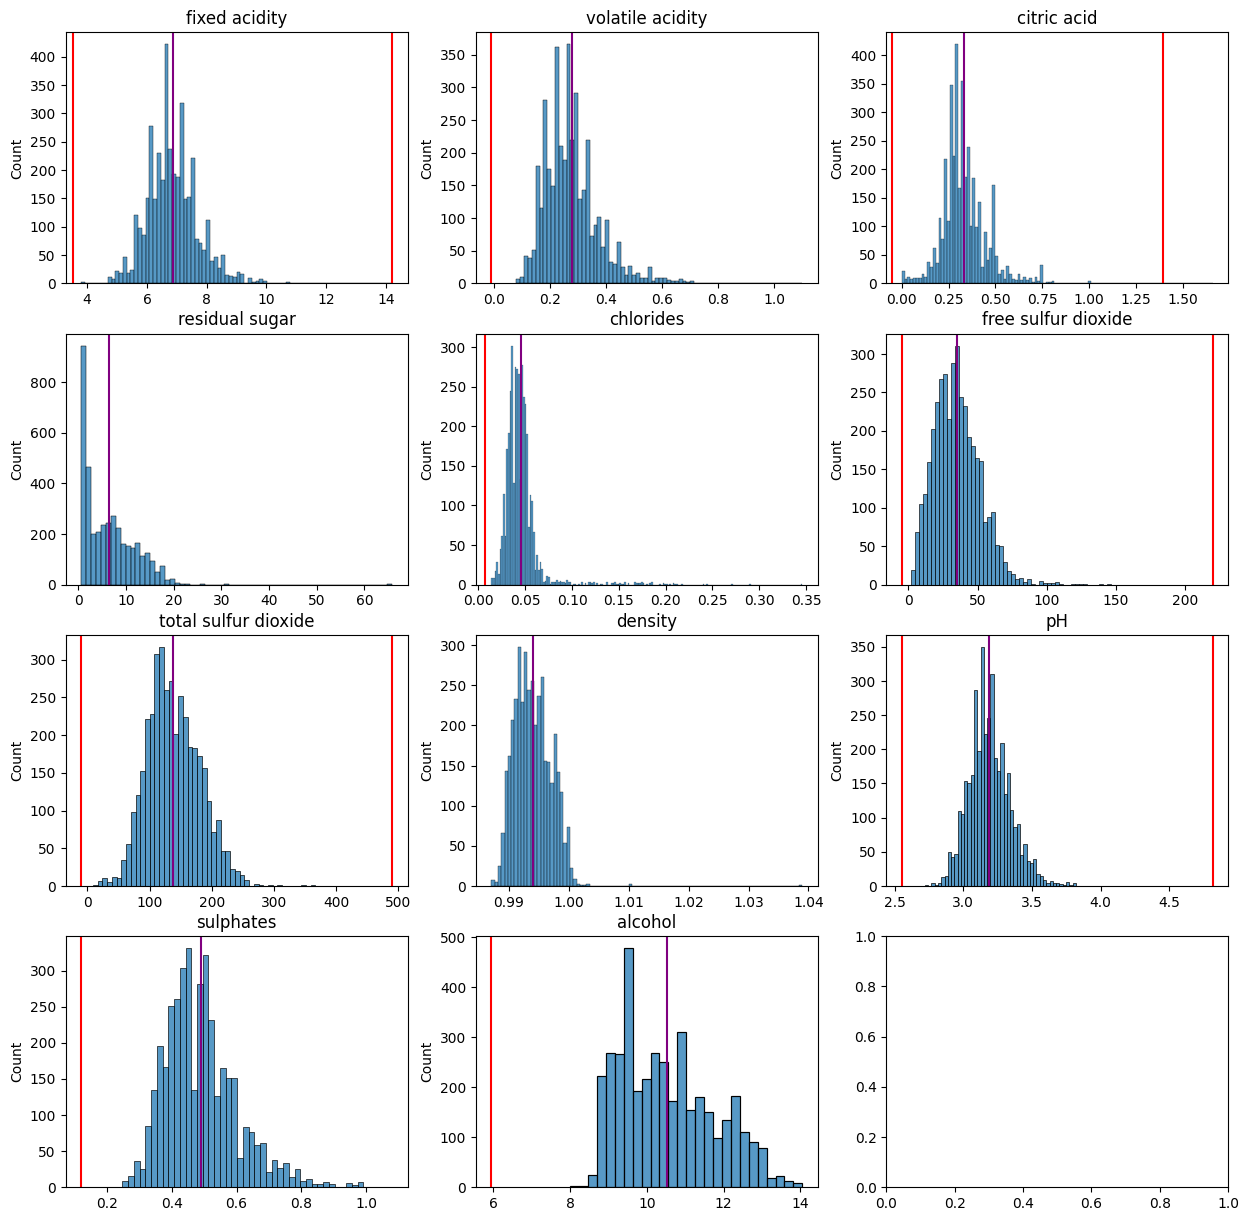

In [15]:
data.plot()

In [16]:
print(f"Accuracy (Outliers not removed): {trainers[0].checkpoint_callback.best_model_score.item()*100:.2f}%")
print(f"Accuracy (Outliers removed): {trainers[1].checkpoint_callback.best_model_score.item()*100:.2f}%")

Accuracy (Outliers not removed): 79.17%
Accuracy (Outliers removed): 78.02%


In [17]:
# sns.pairplot(wine)